# Convex Programming Example 2

This notebook uses convex programming to solve the water allocation problem from Chapter 4 Section 3.3.1 of Loucks, D. P., & van Beek, E. (2017). *Water resources planning and management: An introduction to methods, models, and applications*. $x$ represents the amount of water to allocate to 3 firms and $p$ the amount of product they produce with that water.

In [1]:
!pip install cplex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 11.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import cplex
import cvxpy as cvx

# AW must be nonnegative due to Disciplined Convex Programming (DCP) rules.
AW = cvx.Parameter(nonneg=True)

# Make x and p vector decision variables
x = cvx.Variable(3)
p = cvx.Variable(3)

# Constraints
constraints = [0.4*x[0]**0.9 >= p[0],
               0.5*x[1]**0.8 >= p[1],
               0.6*x[2]**0.7 >= p[2],
               cvx.sum(x) <= AW,
               x >= 0,
               p >= 0]

# Objective function, computed using linear algebra
A1 = np.array([12, 20, 28])
A2 = np.array([1.0, 1.5, 2.5])
B = A1 @ p - A2 @ (p**2)

C = 3*p[0]**1.3 + 5*p[1]**1.2 + 6*p[2]**1.15

obj = cvx.Maximize(B-C)

# Define optimization problem
prob = cvx.Problem(obj, constraints)

# Solve for different values of AW
objs, x_values, p_values = [[] for _ in range(3)]
AW_vals = np.arange(10,41,10)
for AW_val in AW_vals:
    AW.value = AW_val
    prob.solve(solver=cvx.CPLEX)
    objs.append(obj.value)
    x_values.append(x.value)
    p_values.append(p.value)

    print('AW = ', AW.value)
    print('Objective = $%0.2f' % obj.value)
    for i, var in enumerate(x):
      print('X' + str(i+1) + ' = %0.2f' % x[i].value)
      print('P' + str(i+1) + ' = %0.2f' % p[i].value)

    count = 0 # constraint count
    for i, constraint in enumerate(constraints):
      if isinstance(constraint.dual_value, np.ndarray): # vector constraints have a dual for each element
        for j in range(len(constraint.dual_value)):
          count += 1
          print('Constraint %(constraint)d Shadow Price = %(dual)0.2f'
                % {"constraint": count, "dual": constraint.dual_value[j]})
      else:
        count += 1
        print('Constraint %(constraint)d Shadow Price = %(dual)0.2f'
              % {"constraint": count, "dual": constraint.dual_value})
    print('')

AW =  10
Objective = $53.47
X1 = 1.16
P1 = 0.46
X2 = 3.74
P2 = 1.44
X3 = 5.10
P3 = 1.88
Constraint 1 Shadow Price = 8.00
Constraint 2 Shadow Price = 9.24
Constraint 3 Shadow Price = 11.03
Constraint 4 Shadow Price = 2.84
Constraint 5 Shadow Price = 0.00
Constraint 6 Shadow Price = 0.00
Constraint 7 Shadow Price = 0.00
Constraint 8 Shadow Price = 0.00
Constraint 9 Shadow Price = 0.00
Constraint 10 Shadow Price = 0.00

AW =  20
Objective = $74.28
X1 = 4.23
P1 = 1.46
X2 = 7.31
P2 = 2.46
X3 = 8.46
P3 = 2.68
Constraint 1 Shadow Price = 4.70
Constraint 2 Shadow Price = 5.45
Constraint 3 Shadow Price = 6.62
Constraint 4 Shadow Price = 1.47
Constraint 5 Shadow Price = 0.00
Constraint 6 Shadow Price = 0.00
Constraint 7 Shadow Price = -0.00
Constraint 8 Shadow Price = 0.00
Constraint 9 Shadow Price = 0.00
Constraint 10 Shadow Price = 0.00

AW =  30
Objective = $84.30
X1 = 7.52
P1 = 2.46
X2 = 10.74
P2 = 3.34
X3 = 11.74
P3 = 3.36
Constraint 1 Shadow Price = 1.98
Constraint 2 Shadow Price = 2.34
Co

Make a 3 x 1 panel figure showing:  
1) the allocations to each user vs. available water,  
2) the price to each user vs. available water, and  
3) the net benefits vs. available water.

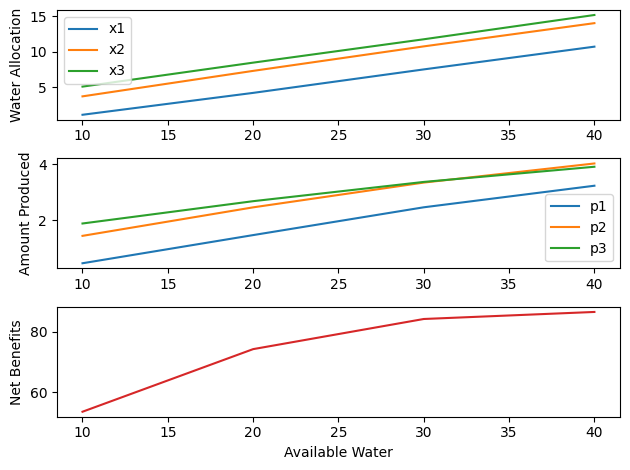

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = fig.add_subplot(311)
for i in range(3):
    ax1.plot(AW_vals, [xi[i] for xi in x_values],label='x' + str(i+1))

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels)
ax1.set_ylabel("Water Allocation")

ax2 = fig.add_subplot(312)
for i in range(3):
    ax2.plot(AW_vals, [pi[i] for pi in p_values],label='p' + str(i+1))

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels)
ax2.set_ylabel("Amount Produced")

ax3 = fig.add_subplot(313)
ax3.plot(AW_vals, objs, color="tab:red")
ax3.set_ylabel("Net Benefits")
ax3.set_xlabel("Available Water")

fig.tight_layout()
fig.show()